# Naive Bayes: Whatsapp messages classification

## Abstract

Using the Whatsapp conversation history, we aim at predicting which member of a group sent a given message. 
This procedure is inspired by the spam email classifier from the Probability and Statistics for Machine Learning and Data Science by DeepLearning.ai


## Method
The classification of messages will use the Bayes theorem under some coarse assumptions. From Bayes theorem, we can write the conditional probability of a message having been sent by a given member as:

$$ p(\text{user} | \text{message} ) = \frac{ p(\text{message} | \text{user} ) \cdot p(\text{user})}{p(\text{message})} $$

First, in contrast to the typical examples of sick vs. healthy, here there is no counterpart to $message$. In other words $p(\text{message}) = 1$, such that the denominator is constant. The term $p(\text{user})$ indicates the probability of a randomly selected message to be of the given user. Thus, this is simply given by:

$$ p( \text{user} ) = \frac{\#  \text{messages by user}}{\# \text{ total messages}} $$

Our next goal is to calculate the conditional probability $p(\text{message} | \text{user} )$. We can do a coarse assumption and consider the probability of a certain message is given by the product of the probabilties of appearence for each word. Thus, every word in independent of any previous word. Under this independence framwework we can write: 

$$ p(\text{message} | \text{user} ) =  \prod_{i=1}^N p( \text{word}_i | \text{user}) $$

where $N$ is the length of the message. The chances of finding a word for a given user is:

$$ p(\text{word}_i | \text{user} ) =  \frac{\#\ \text{occurencies word}_i}{\# \text{words by user}} $$

### Numerical underflow
Since the probabilities are smaller than 1, the product of of $p_i$ will be very small, and numerically untractable for the computer.  We will use logarithms to prevent this issue, and then:

$$ \log [p(\text{user} | \text{message} )] = \sum_{i=1}^N \log[p( \text{word}_i | \text{user}) ]  + \log[p(\text{user})] ,$$

where the term $p(\text{message}) = 1$ is zero after taking logarithms.

We note however that this step is, to some extend, dispensable in the analyis of messages. The reason is that the length of Whatsapp messages is usually very short, and then, the chances of numerical undeflow are small.


In [27]:
import numpy as np
import string

from datetime import date

import matplotlib.pyplot as plt

In [28]:
def load_conversations(path_file):
    """
        Loads the conversation and parses the text for straighforward later manipulation
        Warning: Changes of icons or group names leads to errors in the later extraction of 
                the group members

        Parameters:
            - path_file (string): Path to the conversation file
        
        Returns:
           - messages (array): Array of arrays containing all the words for each message 
           - members_msg (array): User assocaited to each of the messages in messages 
           - members (array): Array with the unique users of the conversation
    """
    messages = [] 
    members_msg = []

    members = []
    members_count = 0

    def is_date(date_str):
        data = date_str.split("/") # Separator character for the date
        if len(data) == 3:
            return 1
        else:
            return 0
    
    def remove_punctuation(input_string):
        """
            Remove punctuation characters from the word lists 
        """
        # Make a translation table that maps all punctuation characters to None
        translator = str.maketrans("", "", string.punctuation)
        result = input_string.translate(translator)
        return result



    with open(path_file) as fp:
       
        for cnt, line in enumerate(fp):
            
            str_line = ''.join(line)
            str_line = str_line.lower()
            str_word_list = str_line.split()
        
            if str_word_list: # Check that it doesnt correspond to an empty message
                if is_date(str_word_list[0]) == 1:
                    
                    # If the line is a citation skip the analyis
                    if (str_word_list[0])[0] == "[":
                        continue
                    
                    msg = [remove_punctuation(s) for s in str_word_list[4:]]
                    messages.append(msg) 

                    tmp_member = str_word_list[3][:-1]  # The -1 is to remove : from the user
                    #tmp_member = str_word_list.split(":")[1].split("-")[1][1:]

                    #if str_word_list[3][-1] == ":":   # We confirm that the last item are : to avoid icon changes

                    members_msg.append(tmp_member)

                    if tmp_member not in members:
                        members.append(tmp_member)
                        members_count += 1


    return messages, members_msg, members

In [29]:
def make_dictionary(messages, members_msg, members):
    """
        Creates a dictionary for every word in the text.
        The dictinary is composed of a dictionary of dictionaries containign the
        word and the number of times each user has employed the word.  For instance,
        
        word_dict = {
                        'hello': {
                                'alice': 1,
                                'bob': 5,
                                'charlie': 3
                            }
                    }

        Parameters:
            - messages (array): Array of arrays containing all the words for each message 
            - members_msg (array): User assocaited to each of the messages in messages 
            - members (array): Array with the unique users of the conversation
        Returns: 
            - word_dict (dictinary of dictionaries):  See description above

    """
    # Creates an empty dictionary
    word_dict = {}

    for idm, message in enumerate(messages):
        mmbr = members_msg[idm]
        for word in message:
            
            # Add word if not in the dictionary
            if word not in word_dict.keys():
                word_dict[word] = {m: 1 for m in members}

            word_dict[word][mmbr] += 1

    return word_dict


In [30]:
def split_data(X, Y, fraction):
    """
        Splits the data in training and cross-validations sets as fraction for training set
        and 1-fraction for the cross-validation data

        Parameters:
            - X (array of arrays, strings) : Messages, composed of array of strings
            - Y (array of strings) : Classes for each user
            - fraction (float) : Proportion of the data to be uset for training
        
        Returns:
            - X_train (array of arrays, strings) : Messages, composed of array of strings for trainign
            - Y_train (array of strings) : Classes for each user for the traning 
            - X_xval (array of arrays, strings) : Messages, composed of array of strings for cross validation
            - Y_xval (array of strings) : Classes for each user for the cross validation 
    """     

    n_messages = len(X)
    num_ones = int(np.round(n_messages*fraction))
    
    ids = np.int32(np.random.choice(n_messages, num_ones, replace=False))

    ids_bool_train = np.zeros(n_messages, dtype=bool)
    ids_bool_xval =  np.zeros(n_messages, dtype=bool)
    ids_bool_train[ids] = True
    ids_bool_xval[~ids_bool_train] = True
    
    # We do it in that way (instead of X[ids]) because of having an array of strings X[messsage][words], 
    # which does not allow for the indicated approach 
    X_train = [X[i] for i in ids]
    X_xval = [X[i] for i in  range(0,n_messages) if ids_bool_xval[i]==True]
   
    Y_train = [Y[i] for i in ids]
    Y_xval = [Y[i] for i in  range(0,n_messages) if ids_bool_xval[i]==True]
    

    return X_train, X_xval, Y_train, Y_xval

In [31]:

def messages_by_member(members_msg, member):
    """
        Rerturns the total number of messages of a member in the conversation
    """
    return sum(np.array(members_msg)==member)


def prob_message_by_members(messages, members_msg, members):
    """
        Creates dictionaries with the number of messages for each of the membeers and their probability

    """
    n_messages = len(messages)
    num_messages_members = {member: messages_by_member(members_msg, member) for member in members}
    prob_message_members =  {member: messages_by_member(members_msg, member)/n_messages for member in members}
    return num_messages_members, prob_message_members


def prob_message_given_member(message, member, word_dictionary, num_messages_by_member, logprobs):
    """
        Calculate the probability of a message from the probability of appearence of words,
        considering them as independent p(message) = prod_i p(word_i)
    """ 

    if logprobs==False:
        p = 1
        for word in message:
            if word in word_dictionary.keys(): 
                p *= word_dictionary[word][member]/num_messages_by_member
    else:
        p = 0
        for word in message:
            if word in word_dictionary.keys(): 
                p += np.log(word_dictionary[word][member]/num_messages_by_member)

    return p 


def naive_bayes_whatsapp_messages(message, members, num_messages_members, prob_message_members, word_dictionary, logprobs = False):    
    """
        Naive Bayes classifier whatsapp member classification.

        This function calculates the probability of a message comming from each of the members
        based on the Naive Bayes algorithm. It uses the conditional probabilities of the
        messages given spam and ham, as well as the prior probabilities of spam and ham
        classes.

        Parameters:
            - message (string array): The whatsapp message.
            - members (array): Array with all the members in the group
            - num_messages_members (array ints): Number of message for each member
            - prob_message_members (array floats): Probability of a member to send a message
            - word_dictionary (dictionary): The dictionary containing the words frequency.

        Returns:
            - most_likely_member (string): name of the member with the highest probability for having sent the message 
            - p_message (dict): dictionary with the probabilities for each member of the group
        
    """

    p_message = {}
    message_words = message.split()
    for member in members:
        p_message_given_member = prob_message_given_member(message_words, member, word_dictionary, num_messages_members[member], logprobs)
        p_member = prob_message_members[member]

        if logprobs==False:
            p_message[member] =  p_message_given_member*p_member
        else:
             p_message[member] =  p_message_given_member + np.log(p_member)
    
    most_likely_member = max(p_message, key=p_message.get)

    return most_likely_member, p_message


In [32]:
# Load conversation
messages, members_msg, members = load_conversations('./chats/chat_ac.txt') 

# Split the data in training and cross-validation sets
TRAINING_FRACTION = 0.8
messages_train, messages_xval, members_msg_train, members_msg_xval  = split_data(messages, members_msg, TRAINING_FRACTION)

# Make dictionary
word_dict_train = make_dictionary(messages_train, members_msg_train, members)


# Determine probabilities per user
num_messages_members, prob_message_members = prob_message_by_members(messages_train, members_msg_train, members)

In [33]:
# Test a sentence
most_likely_member, p_message_per_member = naive_bayes_whatsapp_messages("Hello World!", members, num_messages_members, prob_message_members, word_dict_train, False)

## Assesing the quality of the algorithm 

### Classification matrix

To evaluate the precission of the algorithm, we use the cross-validation set to construct a classification matrix $C$. We compare the answer given by the algorithm with that previously known, and the entries of the classification matrix are probabilities: 

$$ C_{ij} = P(\text{classifying the message as member}_j | \text{message was sent by member}_i)$$

Note that the matrix is not simmetric. Ideally, $C$ should be high in the diagonal and null (or very small) in the non-diagonal terms, i.e. $C_{ii} \approx 1$ and $C_{ij} \approx 1-\delta_{ij}$

This matrix contains useful information that will be used in the determination of the precission of the algorithm. Out first proxy for it, will be the accuracy $\mathcal{A}$ of the algorithm, simply defined here as 

$$  \mathcal{A} = \frac{\# \text{messages correctly classified}}{\# \text{total messagess}} $$

Overall classification accuracy (cross-validation set) A = 0.746
Overall classification accuracy (training set) A = 0.852


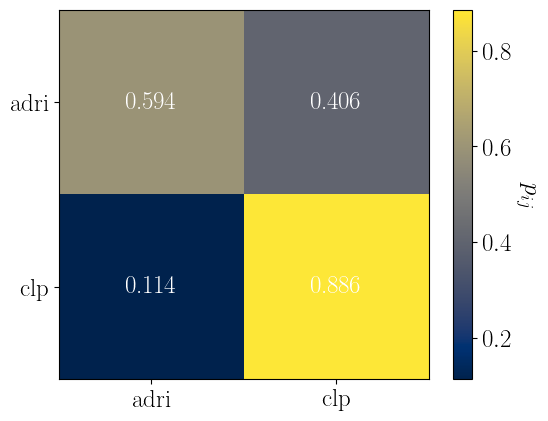

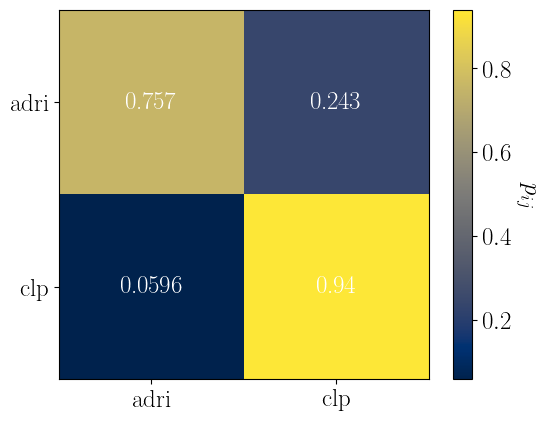

In [34]:
def evaluate_cross_validation(messages, members_msg, members, num_messages_members, prob_message_members, word_dict_train, logprobs=False, plot_precc=True):
    """ 
        This function is used to test the performance of the method. We iterate over all messages in the cross validation set.
        It creates a 2D array reppresenting the probability of predicting a member Y given that the message was sent by X.
        Ideally, it should be very high in the diagonal and null (or very small) in the non-diagonal terms

        Parameters:
            - messages (array): Array of strings with messages
            - members_msg (list): Member associated to each message 
            - members (list): List of all members. 
            - num_messages_members (dict): Total number of messages by a member 
            - prob_message_members (dict): Probability messages by member
            - word_dict_train (dict): Dictionary for the plotting 
            - plot_precc (bool): Boolean to indicate data plotting

        Return:
            - accuracy (double): Acurracy A=#messages correctly classified/#messages total
            - classification_dict_matrix (dict): Dictionary with the probabilities for classifying a message of a member as of other member

    
    """
    n_members = len(members)

    # Create classifciation matrix
    classification_dict_matrix = {}
    for member in members:        
        classification_dict_matrix[member] = {m: 0 for m in members}

    # We iterate over all messages
    for message_arr_fmt, member in zip(messages, members_msg):
        
        # Convert array to string with spaces
        message = " ".join(message_arr_fmt)
        most_likely_member, _ = naive_bayes_whatsapp_messages(message, members, num_messages_members, prob_message_members, word_dict_train, logprobs)
        
        classification_dict_matrix[member][most_likely_member] +=1
    
    # Calculate the Accuracy
    accuracy = 0
    for member in members:
        accuracy +=  classification_dict_matrix[member][member]
    accuracy /= len(members_msg)

    # We rescale by the number of messages of member to find the classifciation probabilities
    for member in members: 
        n_msg_member =  sum(classification_dict_matrix[member].values())
        for m  in members: 
            classification_dict_matrix[member][m] /= n_msg_member


    # Accesory ploting funciton
    if plot_precc == True:

        # Converts the dictionary to a numpy array
        n_members = len(members)
        classification_matrix = np.zeros((n_members, n_members))

        for i in range(0,n_members):
            for j in range(0,n_members):
                classification_matrix[i][j] = classification_dict_matrix[members[i]][members[j]]
        
        # Ploting funcitons
        font = {'family' : 'serif',
                'weight' : 'normal',
                'size'   : 18}

        plt.rc('text', usetex=True)
        plt.rc('font', **font)
        fig, ax = plt.subplots()
        

        im = ax.imshow(classification_matrix, cmap='cividis')

        # Loop over data dimensions and create text annotations.
        for i in range(n_members):
            for j in range(n_members):
                text = ax.text(j, i,  float('%.3g' % classification_matrix[i, j]), ha="center", va="center", color="w")

        # Labels
        ax.set_xticks(np.arange(n_members), labels=members)
        ax.set_yticks(np.arange(n_members), labels=members)

        # Color bar
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel(r"$p_{ij}$", rotation=-90, va="bottom")

            
    return accuracy, classification_dict_matrix

#accuracy, classification_dict_matrix = evaluate_cross_validation(messages_xval, members_msg_xval, members, num_messages_members, prob_message_members, word_dict_train, logprobs=True, plot_precc=True)
#print("Overall classification accuracy (cross-validation set) A = " + str(float('%.3g' % accuracy))  )

accuracy, classification_dict_matrix = evaluate_cross_validation(messages_xval, members_msg_xval, members, num_messages_members, prob_message_members, word_dict_train, logprobs=False, plot_precc=True)
print("Overall classification accuracy (cross-validation set) A = " + str(float('%.3g' % accuracy))  )

accuracy, classification_dict_matrix = evaluate_cross_validation(messages_train, members_msg_train, members, num_messages_members, prob_message_members, word_dict_train, True)
print("Overall classification accuracy (training set) A = " + str(float('%.3g' % accuracy))  )

### Precission and Recall

As a further validation of the method, we will calculate multi-class precission and recall. We will follow the same procedure that we had used in binary classification. In short, we define the preccision $\mathcal{P}$ as

$$ \mathcal{P} = \frac{\# \text{true positives member}_A}{\# \text{true positives member}_A + \# \text{false positives member}_A} $$

and the recall $\mathcal{R}$ as

$$ \mathcal{R} = \frac{\# \text{true positives member}_A }{ \# \text{true positives member}_A + \# \text{false negatives member}_A}. $$ 

From them, we can extract the F1-score:

$$ \text{F1} = 2\frac{\mathcal{P}\mathcal{R}}{\mathcal{P} + \mathcal{R}} $$

These parameters combined allow us to determine the efficiency of the classification algorithm.

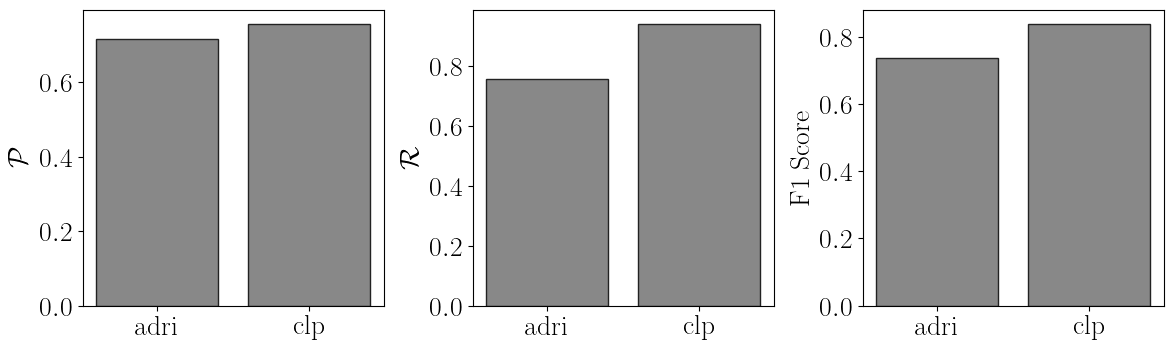

In [35]:
def calc_precission_recall(classification_dict_matrix, members, plot_prf=True):
    """
        Calculate precission, recall and the F1 Score.

        Parameters:
            - classification_dict_matrix (dictionary): Classification matrix defining the probability of classifying a message from a member depending on the member
            - members (list): List for all members in the group  
            - plot_prf (bool): Optional parameter to plot precission, recall and F1 score for each member

        Output:
            - precission_dict (dictionary): Precission for each member
            - recall_dict (dicinary): Recall for each member
            - f1_score_dict (dictionary): F1 score for each member
            
    """
    n_member = len(members)

    precission_dict = {member: 0 for member in members}
    recall_dict = {member: 0 for member in members}
    f1_score_dict = {member: 0 for member in members}

    for member in members:
        true_positives = classification_dict_matrix[member][member]
        
        # Calculate all positives and precission
        all_positives = 0
        for i in members:
            for j in members:
                if i==member or j==member:
                    all_positives += classification_dict_matrix[i][j]

        precission_dict[member] = true_positives/all_positives
            
        
        # Calculate false negatives and recall
        false_negatives = 0
        for m in members:
            if m != member:
                false_negatives += classification_dict_matrix[member][m]

        recall_dict[member] = true_positives/(true_positives + false_negatives)

        # Calculate the f1 score for each member from P and R
        f1_score_dict[member] = 2*(recall_dict[member] * precission_dict[member] )/( precission_dict[member]  + recall_dict[member] )

    #Plot routines
    if plot_prf==True:

        precission = np.array([precission_dict[m] for m in members])
        recall = np.array([recall_dict[m] for m in members])
        f1 = np.array([f1_score_dict[m] for m in members])

        font = {'family' : 'serif',
                'weight' : 'normal',
                'size'   : 20}

        plt.rc('text', usetex=True)
        plt.rc('font', **font)
       
        fig, (ax_p, ax_r, ax_f1) = plt.subplots(1, 3, figsize=(12, 4))
        fig.tight_layout() 
                 
        ax_p.bar(members, precission,  color='#888888',  edgecolor="#222222")
        ax_p.set_ylabel(r"$\mathcal{P}$")

        ax_r.bar(members, recall,  color='#888888',  edgecolor="#222222")
        ax_r.set_ylabel(r"$\mathcal{R}$")

        ax_f1.bar(members, f1,  color='#888888',  edgecolor="#222222")
        ax_f1.set_ylabel(r"F1 Score")
        

    return precission_dict, recall_dict, f1_score_dict

precission_dict, recall_dict, f1_score_dict = calc_precission_recall(classification_dict_matrix, members, plot_prf=True)

## Appendix: Refinements of the method

We can add extra factors to improve the relatively weak prediction ability of the model.  In particular,, we can analyse the total number words (or characters) in a message, Markovianity, and temporal dependencies.

We write the length probability following Bayes:

$$ p(\text{user} | \text{length} ) = \frac{p(\text{length} | \text{user} ) \cdot p(\text{user})}{p(\text{length})}$$


Next, we can use Markvianity as a a model to determine the probabilty of observing a message by $\text{user} = U$ at time $t$ given that the previous message was sent by member $u$ at $t-1$. In mathematical terms $p(\text{messsage}, \text{user}=U, t | \text{user} = u, t-1)$.

From the point of view of temporal dependencies, we can assume that each member will have particular writing times, for instance, due to job constrains, family, etc. Therefore, we could use the time reception of a message as an additional proxy for the identification of the message. We can write that as $p(\text{user} | t)$ and calculate it using Bayes as previously.
Combining everything togeteher, we arrive to:

$$ p() = p()\cdot p() \cdot p(\text{member}(c) | \text{member}(c-1), t ) $$

However, the distribution of length is, in general, very similar between members. The distribution of length for a given users changes between groups, suggesting that the person accomodates its communication to the underlying environmet. This results in a feedback between group members such that all the users communicate similarly.  


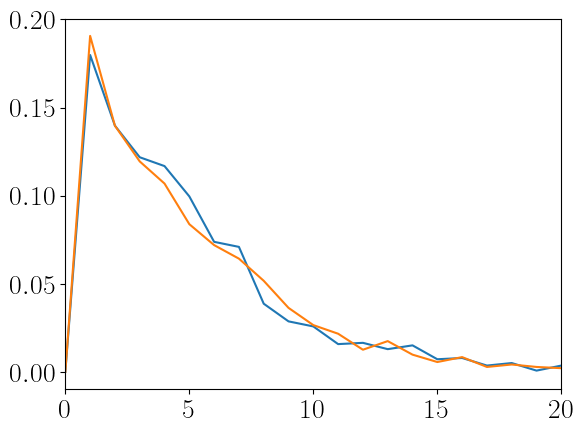

In [40]:
def length_prob(messages, members_msg, members):
    MAX_LENGTH_WORD = 100
    MAX_LENGTH_WORD_CHARS = MAX_LENGTH_WORD*10

    word_length = {member: np.zeros(MAX_LENGTH_WORD)  for member in members}
    prob_word_length = {member: np.zeros(MAX_LENGTH_WORD)  for member in members}

    char_length = {member: np.zeros(MAX_LENGTH_WORD_CHARS)  for member in members}
    prob_char_length = {member: np.zeros(MAX_LENGTH_WORD_CHARS)  for member in members}


    # Word counts
    for message, member in zip(messages, members_msg):
        
        #Count words
        L_msg = len(message)
        if L_msg <= MAX_LENGTH_WORD-1:
            word_length[member][L_msg] += 1
        if L_msg >= MAX_LENGTH_WORD:
            word_length[member][L_msg] += 1

        # Count characters
        n_chars  = 0
        for word in message:
            n_chars += len(word)

        if n_chars <= MAX_LENGTH_WORD_CHARS-1:
            char_length[member][n_chars] += 1
        if L_msg >= MAX_LENGTH_WORD_CHARS:
            char_length[member][n_chars] += 1


    # Probabilities
    p_length_word = np.zeros(MAX_LENGTH_WORD)
    p_char_word = np.zeros(MAX_LENGTH_WORD_CHARS)
    for member in members:
        prob_word_length[member][:] = word_length[member][:]/np.sum(word_length[member][:])
        prob_char_length[member][:] = char_length[member][:]/np.sum(char_length[member][:])
        p_length_word += word_length[member][:]
        p_char_word += char_length[member][:]

    p_length_word /= np.sum(p_length_word)
    p_char_word /= np.sum(p_char_word)

    """    
    for member in members:
        plt.plot(prob_word_length[member])
        plt.xlim([0,20])
    """

    return word_length, prob_word_length, char_length, prob_char_length, p_length_word, p_char_word

word_length, prob_word_length, char_length, prob_char_length, p_length_word, p_char_word = length_prob(messages_xval, members_msg_train, members)